2c
1. Brak opisu źródła, zakresu i sposobu pobrania danych / brak objaśnień i komentarzy do realizowanego przetwarzania danych / niepełny opis wykresu 0.5

3d
1. Brak przedstawienia wielkości proponowanych do analizy zależności oraz 1, 2 z 2c 0.5
5. Brak wyznaczenia parametrów modelu liniowego 0.5
6. Brak wyznaczenia parametrów modelu wielomianowego 0.5
8. Brak badania wpływu proporcji podziału zbioru danych na zbiór uczący i zbiór testujący na wartość kryterium (błędu) średniokwadratowego 1.0 
9. Brak objaśnień i komentarzy do realizowanego przetwarzania danych 0.5

4b
5. Brak estymacji parametrów rozkładu normalnego lub implementacji estymatora Parzena z sensownymi wartościami h 1.0 (np. za za małe h 0.25)
8. Brak objaśnień i komentarzy do realizowanego przetwarzania danych 0.5

Zaimportowanie wszystkich wykorzystywanych bibliotek oraz zmiana ustawień pandas, aby wyświetlać wszystkie wiersze tabeli na raz

In [97]:
import numpy as np
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import random
from scipy import optimize
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats
import squarify

import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

pd.set_option('display.max_rows', None)
pd.options.mode.chained_assignment = None

Wykorzystywane dane zostały pobrane z https://www.kaggle.com/datasets/piterfm/2022-ukraine-russian-war?resource=download z którego zostały umieszczone na moim prywatnym GitHubie, ze względu na dosyć skomplikowane pobieranie z tej strony internetowej (mozna pobierać tylko po zalogowaniu, a po wielu próbach cały czas mnie odrzucało). Dane obejmują informacje o stratach w sprzęcie po stronie rosyjskiej w trakcie wojny rosyjsko-ukraińskiej. Zawiera liczby zniszczonych pojazdów zarówno lądowych, jak i powietrznych, a takze wodnych.

Dane w większości są zapisane jako stringi, dlatego większość najpierw zapisuję, ze prawie wszystkie kolumny przechowują liczby całkowite, z wyjątkiem daty, którą zamieniam na DateTime oraz z wyjątkiem pojazdów militarnych oraz cystern, które są początkowo zapisane w formacie zmiennoprzecinkowym. W związku z tym, ze później te dane zmiennoprzecinkowe są połączone, dokonuję zsumowania wartości tych kolumn, aby w kolejnym kroku usunąć juz wszystkie zbędne kolumny (zbędne, poniewaz mają za duzo pustych wartości). W niektórych momentach weryfikuję, czy tabela zawiera pola puste.

In [98]:
csv_url = "https://raw.githubusercontent.com/Topaz-Frog/ru_losses/main/russia_losses_equipment.csv?token=GHSAT0AAAAAABVOT4UG2TOX77TFPPRL3CX6YVF3OJQ"
# csv_file = "russia_losses_equipment.csv"
df_total = pd.read_csv(csv_url)
print(df_total.columns[df_total.isna().any()].tolist())

df_total.date = pd.to_datetime(df_total.date, format='%Y-%m-%d')
df_total.day = df_total.day.astype(int)
df_total.aircraft = df_total.aircraft.astype(int)
df_total.helicopter = df_total.helicopter.astype(int)
df_total.tank = df_total.tank.astype(int)
df_total.APC = df_total.APC.astype(int)
df_total["field artillery"] = df_total["field artillery"].astype(int)
df_total.MRL = df_total.MRL.astype(int)
df_total["military auto"] = df_total["military auto"].astype(float)
df_total["fuel tank"] = df_total["fuel tank"].astype(float)
df_total.drone = df_total.drone.astype(int)
df_total["naval ship"] = df_total["naval ship"].astype(int)
df_total["anti-aircraft warfare"] = df_total["anti-aircraft warfare"].astype(int)
df_total['vehicles and fuel tanks']= df_total['vehicles and fuel tanks'].astype(float)

i=0
while i<=58:
    df_total["vehicles and fuel tanks"][i]=df_total["military auto"][i]+df_total['fuel tank'][i]
    i+=1

print(df_total.columns[df_total.isna().any()].tolist())

df_total.drop(columns=['special equipment','mobile SRBM system','cruise missiles','greatest losses direction','military auto','fuel tank'],inplace=True)
df_total['vehicles and fuel tanks']= df_total['vehicles and fuel tanks'].astype(int)

print(df_total.columns[df_total.isna().any()].tolist())

# display(df)

['special equipment', 'mobile SRBM system', 'vehicles and fuel tanks', 'cruise missiles', 'greatest losses direction']
['special equipment', 'mobile SRBM system', 'cruise missiles', 'greatest losses direction']
[]


In [99]:
needed_list=["aircraft","helicopter","tank","APC","field artillery","MRL","drone","naval ship","anti-aircraft warfare","vehicles and fuel tanks"]

daily_df = df_total.copy()
for (columnName, columnData)  in daily_df.iteritems():
    if columnName in needed_list:
        i=0
        new_list=[]
        new_list.append(columnData[0])
        while i<len(columnData)-1:
            n=columnData[i+1]- columnData[i]
            new_list.append(n)
            i=i+1
        # print(new_list)
        
        # Drop that column
        daily_df.drop(columnName, axis = 1, inplace = True)

        # Put whatever series you want in its place
        daily_df[columnName] = new_list

In [100]:
x = df_total['date']
y0 = df_total['aircraft']
y1 = df_total['helicopter']
y2 = df_total['anti-aircraft warfare']
y3 = df_total['drone']

fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=y0,
                    mode='lines+markers',
                    name='Aircraft'))
fig.add_trace(go.Scatter(x=x, y=y1,
                    mode='lines+markers',
                    name='Helicopter'))
fig.add_trace(go.Scatter(x=x, y=y2,
                    mode='lines+markers',
                    name='Anti-aircraft warfare'))
fig.add_trace(go.Scatter(x=x, y=y3,
                    mode='lines+markers',
                    name='Drone'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=0, y=1, traceorder="normal"),
                  title="Weapons: Air",
                  xaxis_title="Date",
                  yaxis_title="Weapons ",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

In [101]:
x = df_total['date']
y0 = df_total['tank']
y1 = df_total['field artillery']
y2 = df_total['APC']
y3 = df_total['vehicles and fuel tanks']

fig = go.Figure()

fig.add_trace(go.Scatter(x=x, y=y0,
                    mode='lines+markers',
                    name='Tank'))
fig.add_trace(go.Scatter(x=x, y=y1,
                    mode='lines+markers',
                    name='Field artillery'))
fig.add_trace(go.Scatter(x=x, y=y2,
                    mode='lines+markers',
                    name='APC'))
fig.add_trace(go.Scatter(x=x, y=y3,
                    mode='lines+markers',
                    name='vehicles and fuel tanks'))
fig.update_layout(legend_orientation="h",
                  legend=dict(x=0, y=1, traceorder="normal"),
                  title="Weapons: Ground, Other",
                  xaxis_title="Date",
                  yaxis_title="Weapons ",
                  margin=dict(l=0, r=0, t=30, b=0))
fig.show()

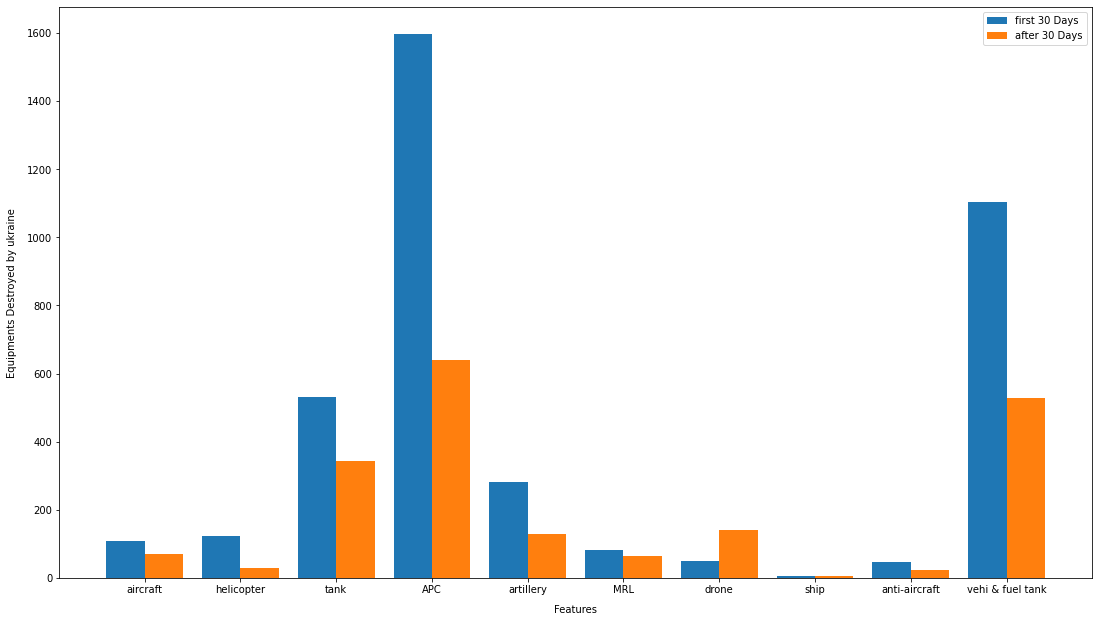

In [102]:
df = daily_df.copy()
bar1_main=[]
bar2_main=[]
for (columnName, columnData)  in df.iteritems():
    X_axis = np.arange(len(needed_list))
    if columnName in needed_list:
        bar1=columnData[:28].sum()
        bar2=columnData[28:].sum()
        bar1_main.append(bar1)
        bar2_main.append(bar2)
        
plt.bar(X_axis - 0.2, bar1_main , 0.4, label = 'first 30 Days')
plt.bar(X_axis + 0.2, bar2_main , 0.4, label = 'after 30 Days')
plot_name=["aircraft","helicopter","tank","APC","artillery","MRL","drone","ship","anti-aircraft","vehi & fuel tank"]
plt.xticks(X_axis, plot_name)
fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)
plt.legend()
plt.xlabel("Features",labelpad=10)
plt.ylabel("Equipments Destroyed by ukraine",labelpad=10)
plt.show()

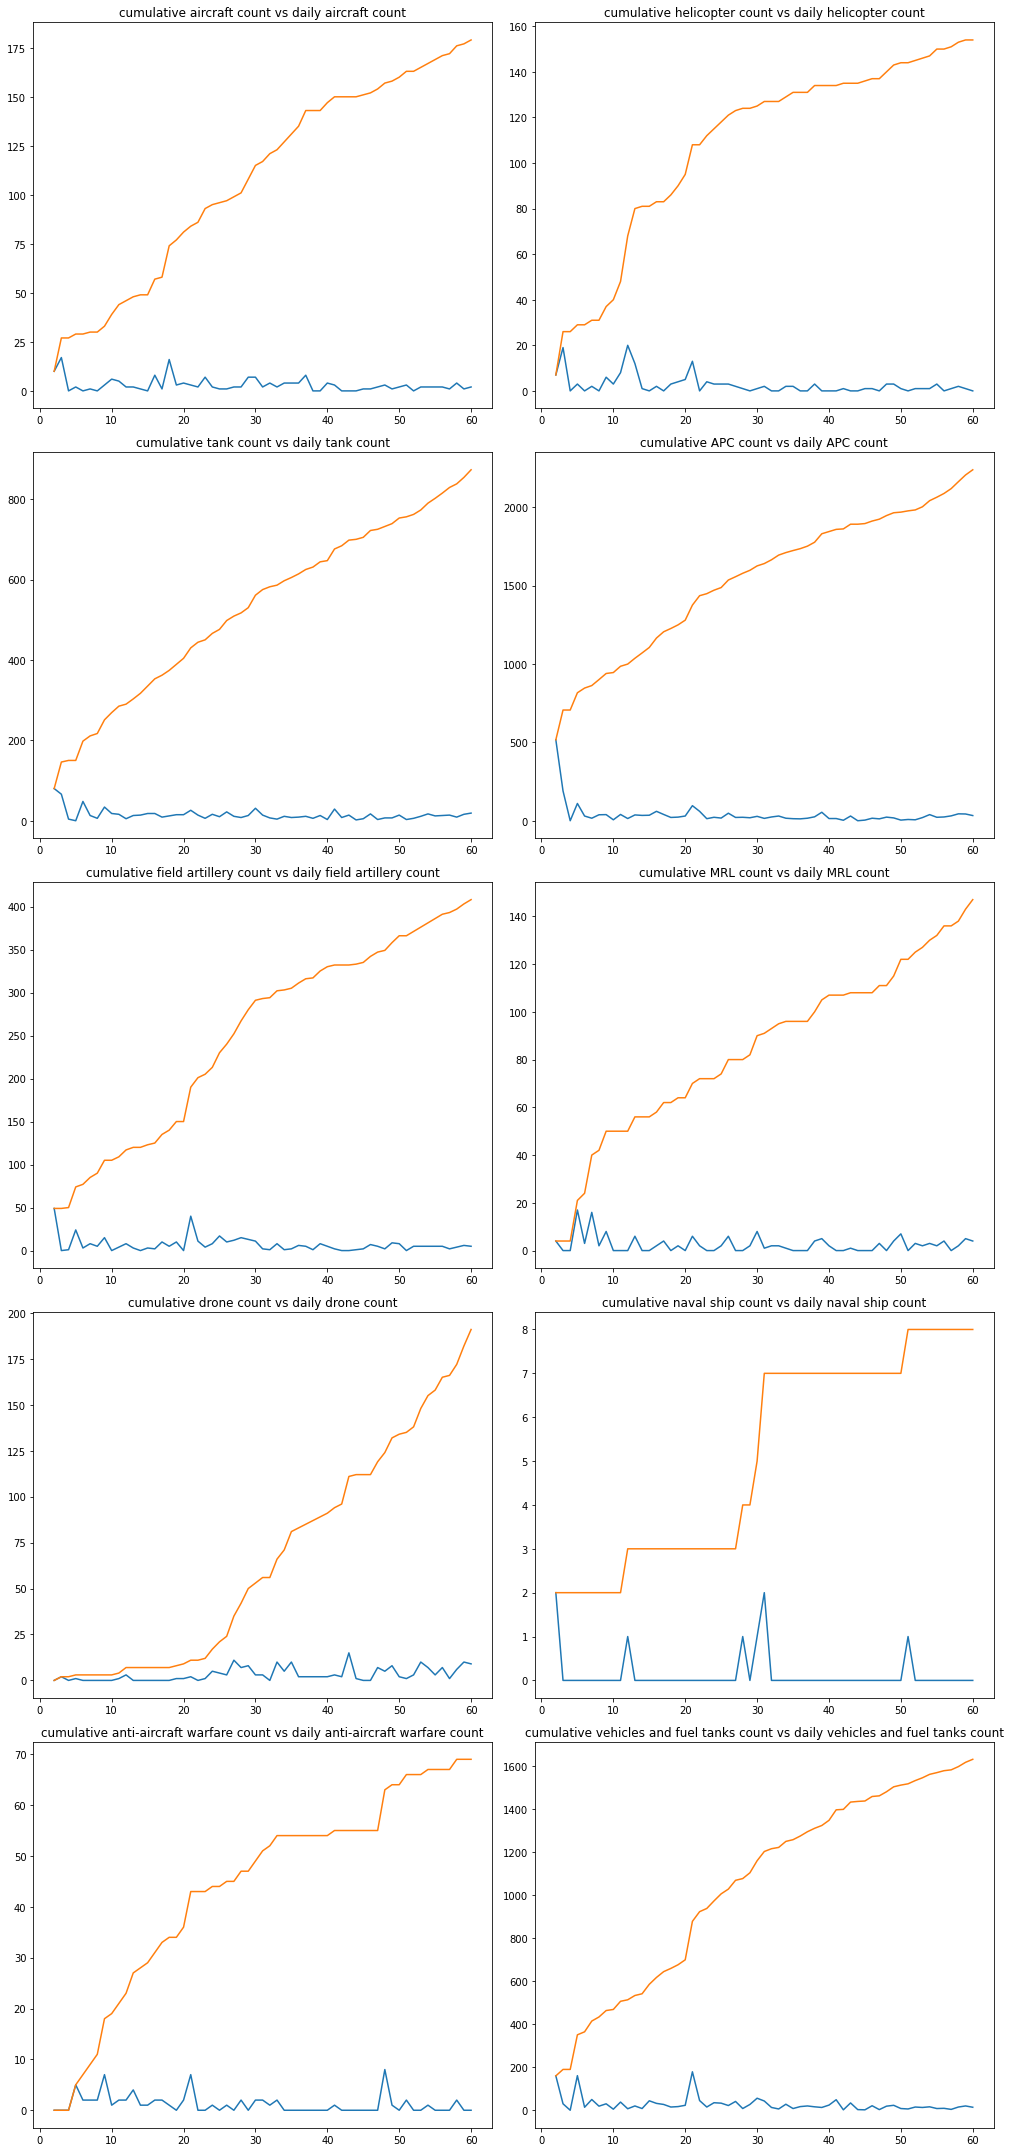

In [103]:
df = daily_df.copy()

fig, axs = plt.subplots(5, 2, figsize=(14,30))
df_subcopy = df_total.copy()

r=0
c=0

for (columnName_1, columnData_1)  in df.iteritems():
    for (columnName_2, columnData_2)  in df.iteritems():
        if columnName_1=="day" and columnName_2 in needed_list:
            if c>1:
                r+=1
                c=0
            data=[df[columnName_1],df[columnName_2],df_subcopy[columnName_2]]
            headers=["day","daily_aircraft_count","cumulative aircraft count"]
            axs[r,c].plot(pd.concat(data,axis=1,keys=headers).set_index('day'))
            # axs[r,c].xlabel("Days")
            # axs[r,c].ylabel("count of destroyed")
            axs[r,c].set_title("cumulative "+columnName_2+" count vs daily "+columnName_2+" count")
            # axs[r,c].show()
            c+=1
fig.tight_layout()

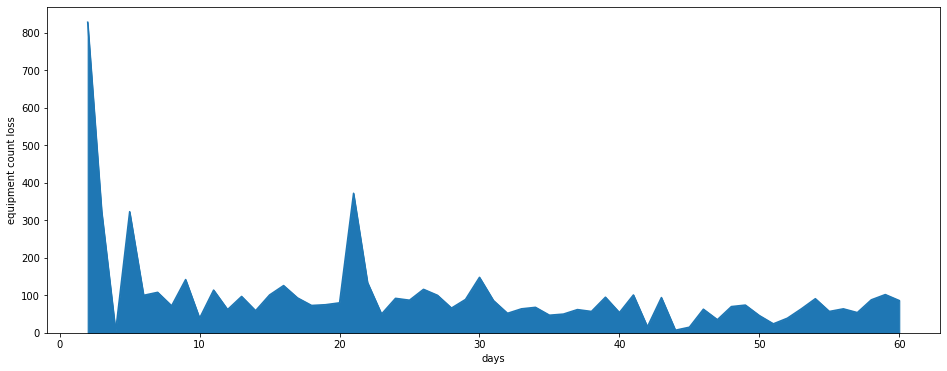

In [104]:
total_loss_day_basis = df.copy()
total_loss_day_basis.drop(columns={'date'}, inplace=True)
total_loss_day_basis.set_index('day', inplace=True)
total_loss_day_basis['Daily equipment loss'] = pd.DataFrame(total_loss_day_basis.sum(axis=1))
total_loss_day_basis['Daily equipment loss'].plot(figsize=(16,6),kind="area")
plt.xlabel('days')
plt.ylabel('equipment count loss')
plt.show()

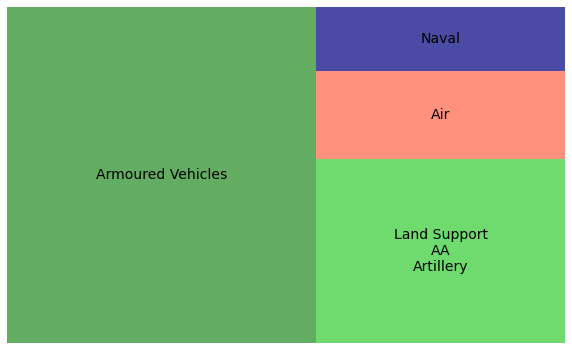

In [105]:
df = daily_df.copy()
fig, ax = plt.subplots(figsize= (10,10*0.618))

air_losses = df[['aircraft', 'helicopter', 'drone']].sum(axis=1)
land_armoured_losses = df[['tank', 'APC']].sum(axis=1)
land_support_losses = df[['field artillery', 'MRL', 'vehicles and fuel tanks', 'anti-aircraft warfare']].sum(axis=1)
sea_losses = df_total[['naval ship']].sum(axis=1)

Casualty_dict = {
    'Armoured Vehicles' : land_armoured_losses.tail(1).values,
    'Land Support\nAA\nArtillery' : land_support_losses.tail(1).values,
    'Air' : air_losses.tail(1).values,
    'Naval' : sea_losses.tail(1).values
}
colors = ['foresTgreen','limegreen','tomato','navy']

# Casualty_dict
df = pd.DataFrame(Casualty_dict)

squarify.plot(sizes = list(Casualty_dict.values()), label = list(Casualty_dict.keys()), color=colors, alpha=.7, text_kwargs={'fontsize':14})
plt.axis('off')
plt.show()

Przygotowanie danych do testów - dla wybranych kolumn dane mają stanowić róznicę między dniem poprzednim, a biezącym.

In [106]:
# df_reversed = df.iloc[::-1]

# for index, row in df_reversed.iterrows():
#     if index >= 1:
#         df.tank[index] -= df.tank.loc[[index-1]]

Wybranie danych do badanego zbioru.

In [107]:
df = daily_df.copy()
X = df.tank.values
print(f"Czołgów: {X.sum()}")

Czołgów: 873


Wykonanie testów Shapiro i D'Agostino dla zbiorów wartości

In [108]:
print(f'Cały zbiór | test Shapiro, p-wartość = {stats.shapiro(X)[1]}')
print(f'Cały zbiór | test D’Agostino i Pearsona, p-wartość = {stats.normaltest(X)[1]}\n')

Cały zbiór | test Shapiro, p-wartość = 5.376130651768563e-10
Cały zbiór | test D’Agostino i Pearsona, p-wartość = 1.216743906294764e-13



W związku z bardzo niskimi p-wartościami (poniej 0.05) odrzucona moze zostać hipoteza ze dane mają rozkład normalny, wybieramy esstymator nieparametryczny (Parzena)

Zaimplementowanie funkcji jądrowej

In [109]:
def K(x):
    return np.exp(-x**2/2)/np.sqrt(2*np.pi)

Wizualizacja danych na wykresie dla szerokości okna 0.5, 1.0 oraz 5.0

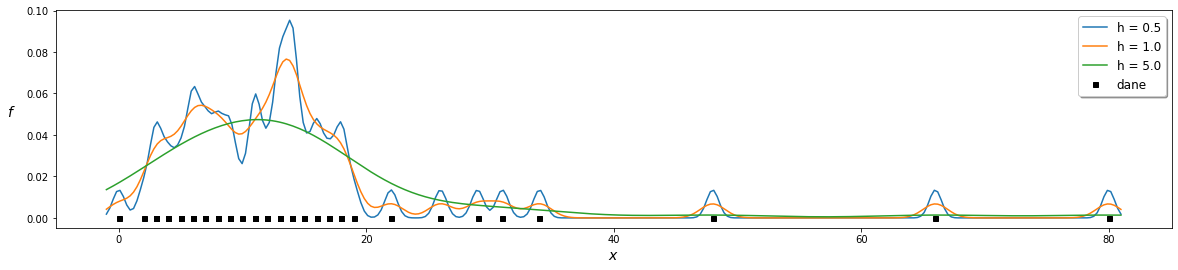

In [110]:
os_x = np.linspace(X.min()-1, X.max()+1, num=300)
H = [0.5, 1.0, 5.0]
N = X.size

plt.figure(figsize=(20,4))
for h in H:
    suma = 0
    for nr, pomiar in enumerate(X):
        suma += K((os_x-pomiar)/h)
        # plt.annotate(r'$x_{}$'.format(nr+1), xy=[X[nr],0.05], horizontalalignment='center', fontsize=10)
    os_y = suma/(h*N)
    plt.plot(os_x, os_y, label=f'h = {h}')

plt.plot(X, np.zeros_like(X) , 's', markersize=5, color='black', label='dane')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$f$', fontsize=14, rotation='horizontal', labelpad=15)
plt.legend(fontsize=12, shadow=True)
plt.show()

Wprowadzenie wybranych danych do badania charakteru ich zalezności. Za proporcje podziału podanego zbioru przyjmujemy 20%, 40% i 80%.

Parametry modelu liniowego: [12.49316], 141.93055
Błąd średniokwadratowy modelu liniowego: 7.65e+02

Parametry modelu GLM: [ 0.     18.1793 -0.093 ], 81.94355
Błąd średniokwadratowy modelu GLM: 2.11e+02



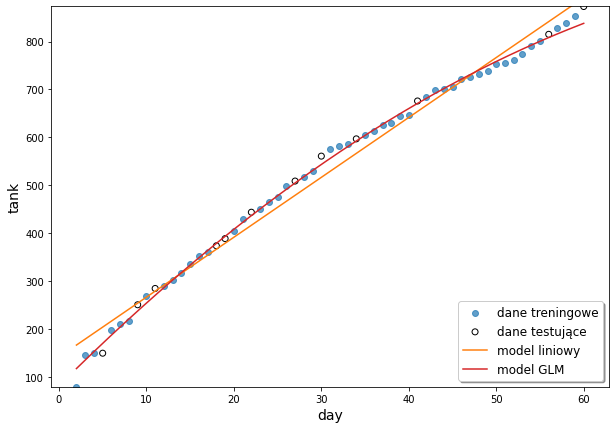

Parametry modelu liniowego: [12.18739], 157.23572
Błąd średniokwadratowy modelu liniowego: 9.84e+02

Parametry modelu GLM: [ 0.     18.0044 -0.0918], 87.46173
Błąd średniokwadratowy modelu GLM: 2.04e+02



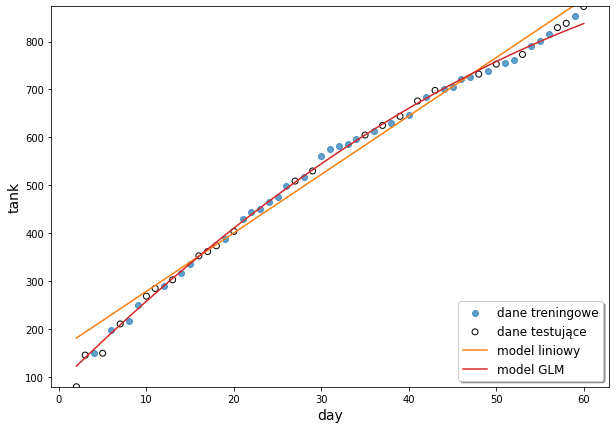

Parametry modelu liniowego: [12.82233], 141.95271
Błąd średniokwadratowy modelu liniowego: 8.18e+02

Parametry modelu GLM: [ 0.     18.4863 -0.1017], 86.86642
Błąd średniokwadratowy modelu GLM: 1.8e+02



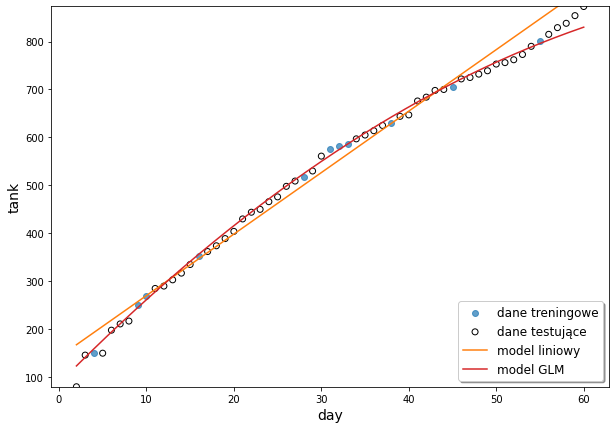

In [111]:
X = df_total.day.values
Y = df_total.tank.values

for i in range(3):
    if i == 0:
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)
    elif i == 1:
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.4)
    else:
        X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.8)
    
    # =========  Model liniowy =========
    from sklearn.linear_model import LinearRegression
    model_lin = LinearRegression()
    model_lin.fit(X_train.reshape(-1,1), 
                Y_train)
    print(f'Parametry modelu liniowego: {np.round(model_lin.coef_,5)}, {np.round(model_lin.intercept_,5)}')
    MSE_lin = mean_squared_error(Y_test, model_lin.predict(X_test.reshape(-1,1)))
    print(f'Błąd średniokwadratowy modelu liniowego: {MSE_lin:0.3}\n')

    # ===== Uogólniony model liniowy (ang. Generalized Linear Model) =====
    from sklearn.preprocessing import PolynomialFeatures
    model_GLM = LinearRegression()
    gen_features = PolynomialFeatures(degree=2, include_bias=True, interaction_only=False)
    model_GLM.fit(gen_features.fit_transform(X_train.reshape(-1,1)), 
                Y_train)
    print(f'Parametry modelu GLM: {np.round(model_GLM.coef_,4)}, {np.round(model_GLM.intercept_,5)}')
    MSE_GLM = mean_squared_error(Y_test, model_GLM.predict(gen_features.fit_transform(X_test.reshape(-1,1))))
    print(f'Błąd średniokwadratowy modelu GLM: {MSE_GLM:0.3}\n')

    # Predykcje wszystkich modeli dla całego zakreso osi X
    os_x = np.linspace(start=X.min(), stop=X.max(), num=300)
    y_lin_pred = model_lin.predict(os_x.reshape(-1,1))
    y_GLM_pred = model_GLM.predict(gen_features.fit_transform(os_x.reshape(-1,1)))

    # Wizualizacja
    plt.figure(figsize=(10,7))
    plt.scatter(X_train, Y_train, label='dane treningowe', alpha=0.7)
    plt.scatter(X_test, Y_test, edgecolor='black', facecolor='none', label='dane testujące')
    plt.plot(os_x, y_lin_pred, label='model liniowy', color='tab:orange')
    plt.plot(os_x, y_GLM_pred, label=f'model GLM', color='tab:red')
    plt.xlabel(df_total.columns[1], fontsize=14)
    plt.ylabel(df_total.columns[4], fontsize=14)
    plt.legend(fontsize=12, shadow=True, loc='lower right')
    plt.ylim([Y.min()-0.1, Y.max()+0.5])
    plt.show()

Jak mozna zauwazyć zarówno model kwadratowy jak i liniowy mają bardzo niski błąd średniokwadratowy. Co więcej model GLM w kazdym z testów wynosi/jest bardzo zblizony do zera, co oznacza ze przypomina ten liniowy. Stąd mogę wywnioskować, ze dane mają zalezność liniową

Dodanie funkcji rysującej historię poszukiwania rozwiązania optymalnego.
W ramach tej listy będziemy pracować na liczbie zniszczonych czołgów zalenie od dnia od rozpoczęcia wojny ukraińsko-rosyjskiej.

In [112]:
def pokaz_2D(Fcelu, x_historia, zakres):
  x_pocz, x_opt = x_historia[0], x_historia[-1]
  os_x1 = np.linspace(zakres[0], zakres[1], num=100)
  os_x2 = np.linspace(zakres[2], zakres[3], num=100)
  siatka_X1, siatka_X2 = np.meshgrid(os_x1, os_x2)
  macierz_Z = Fcelu([siatka_X1, siatka_X2])

  fig, ax = plt.subplots(figsize=(8,8))
  cplot = ax.contourf(siatka_X1, siatka_X2, macierz_Z, 10, cmap='Spectral_r', alpha=1)
  clines = ax.contour(siatka_X1, siatka_X2, macierz_Z, 10, colors='black')
  for punkt in x_historia:
      ax.plot(punkt[0], punkt[1], 'o', 
              color='white', markeredgecolor='black', markersize=5, alpha=0.7)
  ax.plot(x_pocz[0], x_pocz[1], 'd', 
          color='gray', markeredgecolor='black', markersize=10, alpha=0.7)    
  ax.plot(x_opt[0], x_opt[1], 'h', 
          color='white', markeredgecolor='black', markersize=15)
  ax.set_aspect('equal')
  ax.set_xlabel(r'$x_1$', fontsize=16)
  ax.set_ylabel(r'$x_2$', fontsize=16)
  ax.clabel(clines)
  fig.colorbar(cplot)
  return fig, ax

Dodanie za funkcję celu funkcję obliczającą funkcję najmniejszych kwadratów:
\begin{equation}
Q(a,b) = \frac{1}{N}\sqrt{\sum_{i=1}^Ne_i^2}\
\end{equation}
gdzie wstawiamy za a,b je reprezentujące v

Optimization terminated successfully.
         Current function value: 3.371495
         Iterations: 74
         Function evaluations: 142


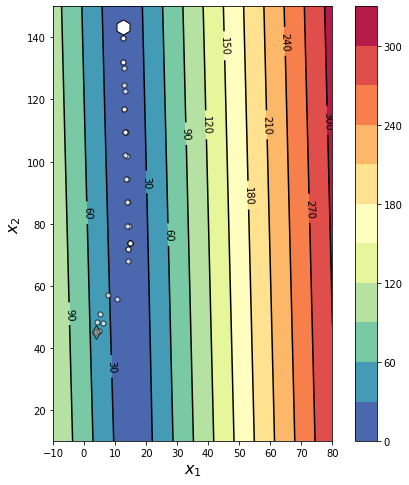

Optimum jest w punkcie [ 12.48533163 143.412353  ]

Optimization terminated successfully.
         Current function value: 3.371495
         Iterations: 69
         Function evaluations: 131


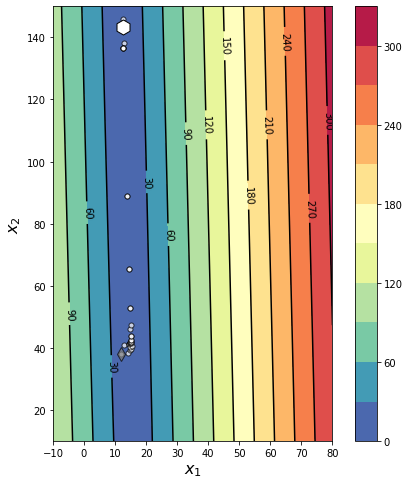

Optimum jest w punkcie [ 12.48533087 143.41235255]

Optimization terminated successfully.
         Current function value: 3.371495
         Iterations: 82
         Function evaluations: 155


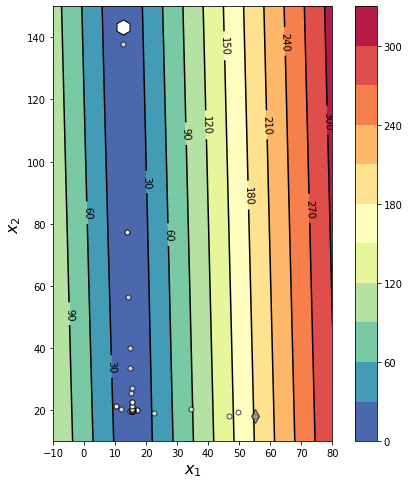

Optimum jest w punkcie [ 12.48532973 143.41243528]



In [115]:
X = df_total.day.values
Y = df_total.tank.values

def lin(v, x):
  a,b = v
  return a*x + b

def Fcelu(v):
  s = 0
  for i in range(0,len(X)):
    s += (Y[i] - lin(v, X[i]))**2
  return s**(1/2)/len(X)

for i in range(3):
    x_opt, x_historia = optimize.fmin(Fcelu,
                                  random.choices(X, k=2),
                                  retall=True)

    zakres=[-10, 80, 10, 150]
    pokaz_2D(Fcelu, x_historia, zakres)
    plt.show()
    print(f'Optimum jest w punkcie {x_opt}\n')

Jak mozna zauwazyć uzyskano 3-krotnie uzyskano tą samą wartość funkcji (3.3715) z optimum w mniej więcej tym samym punkcie (12.4853, 143.4124), niezaleznie od punktu startowego, dlatego mozna śmiało załozyć ze funkcja działa jak najbardziej poprawnie i uzyskuje poprawne optimum. 
Poprawny model liniowy:
\begin{equation}
f(x) = 12.4853 * x + 143.4124
\end{equation}

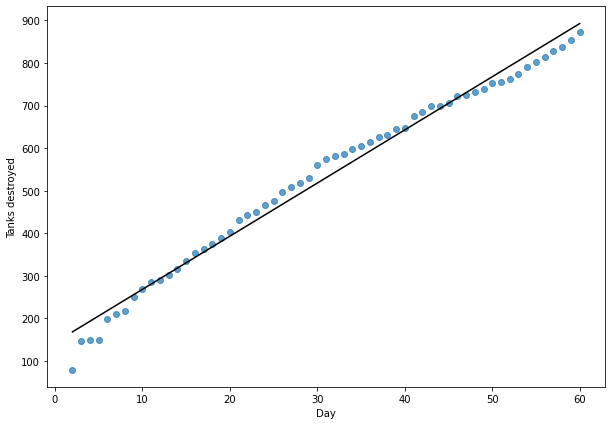

In [114]:
os_x = np.linspace(start=X.min(),stop=X.max(),num=100)

plt.figure(figsize=(10,7))
plt.scatter(X,Y,alpha=0.7)
plt.xlabel("Day")
plt.ylabel("Tanks destroyed")
plt.plot(os_x,lin(x_opt,os_x),color='black',label='model liniowy')
plt.show()

Jak mozna porównać z dodanym powyzej wynikiem z zadania 3, otrzymujemy bardzo zblizony lub ten sam model liniowy dla obu metod wyznaczania parametrów a i b modelu liniowego opisującego zalezność między danymi.